# Crystal Growth
Here we demonstrate crystallisation on the surface of a liquid due to cooling from [@Guyer].

Let us first set up the grid and the function space. We use the default DoF storage available in ```dune-fem``` - this can be changed for example to ```istl``` or ```petsc```.

In [1]:
import matplotlib
matplotlib.rc( 'image', cmap='jet' )

import dune.fem as fem
from dune.grid import cartesianDomain
from dune.alugrid import aluConformGrid as leafGridView
from dune.fem.view import adaptiveLeafGridView as adaptiveGridView
from dune.fem.space import lagrange as solutionSpace

order = 1
dimDomain = 2     # we are solving this in 2D
dimRange = 2      # we have a system with two unknowns
domain = cartesianDomain([4, 4], [8, 8], [3, 3])
gridView  = adaptiveGridView( leafGridView( domain ) )
space = solutionSpace(gridView, dimRange=dimRange, order=order, storage="fem")

We want to solve the following system of equations of variables $\phi$ (phase field) and $T$ (temperature field)

\begin{equation}
\begin{aligned}
\tau \frac{\partial \phi}{\partial t} &= \nabla \cdot D \nabla \phi + \phi(1-\phi)m(\phi, T), \\
\frac{\partial T}{\partial t} &= D_T \nabla^2 T + \frac{\partial \phi}{\partial t},
\end{aligned}
\end{equation}

where $D_T$ = 2.25, m is given by

\begin{equation*}
m(\phi, T) = \phi - \frac{1}{2} - \frac{\kappa_1}{\pi} \arctan(\kappa_2 T),
\end{equation*}

D is given by

\begin{equation*}
D = \alpha^2(1+c\beta)\left(\begin{array}{cc}
1 + c\beta & -c \frac{\partial \beta}{\partial \psi} \\
c \frac{\partial \beta}{\partial \psi} & 1+c\beta
\end{array}\right),
\end{equation*}

and where $\beta = \frac{1-\Phi^2}{1+\Phi^2}$, $\Phi = \tan \left( \frac{N}{2} \psi \right)$, $\psi = \theta + \arctan \left(\frac{\partial \phi/ \partial y}{\partial \phi / \partial x} \right)$ and $\theta$, $N$ are constants.

Let us first set up the parameters for the problem.

In [2]:
alpha        = 0.015
tau          = 3.e-4
kappa1       = 0.9
kappa2       = 20.
c            = 0.02
N            = 6.

We define the initial data and create a function from it. We use this value to set up our solution.

In [3]:
from dune.fem.function import globalFunction
from ufl import dot,sqrt,conditional,as_vector, SpatialCoordinate
x = SpatialCoordinate(space)
r = sqrt( dot( x-as_vector([6,6]), x-as_vector([6,6])) )
initial = as_vector( [conditional(r>0.3,0,1), -0.5] )
u_h = space.interpolate(initial, name="solution")
u_h_n = u_h.copy()

As we will be discretising in time, we define the unknown data as $u = (\phi_1, \Delta T_1)$, while given data (from the previous time step) is $u_n = (\phi_0, \Delta T_0)$ and test function $v = (v_0, v_1)$.

In [4]:
from ufl import TestFunction, TrialFunction
from dune.ufl import Constant
u = TrialFunction(space)
v = TestFunction(space)
dt = Constant(0, "dt")    # time step

For the numerical scheme, we discretise the time derivatives in the usual way, and we obtain the weak form by multiplying by a test function and integrating by parts. We also express the system using vectors.

This gets us the following equation.

\begin{equation}
\int \left( \alpha^2 \frac{dt}{\tau} (D_n\nabla \phi_1) \cdot \nabla v_0 + dt \ D_T \nabla T_1 \cdot \nabla v_1 + \textbf{u} \cdot \textbf{v} - \textbf{s} \cdot \textbf{v} \right) \ dx
=
\int (\textbf{u}_n \cdot \textbf{v} - \phi_0 v_1) \ dx
\end{equation}

where

\begin{equation}
\textbf{s} = \left( \frac{dt}{\tau}\phi_1(1-\phi_1)m(\phi_1, T_1), \phi_1 \right)^T
\end{equation}

and

$D_n$ is the anisotropic diffusion using the previous solution $\textbf{u}_n$ to compute the entries.

First we put in the right hand side which only contains explicit data.

In [5]:
from ufl import inner, dx
a_ex = (inner(u_h_n, v) - inner(u_h_n[0], v[1])) * dx

For the left hand side we have the spatial derivatives and the implicit parts.

In [6]:
from ufl import pi, atan, atan_2, tan, grad, inner
psi        = pi/8.0 + atan_2(grad(u_h_n[0])[1], (grad(u_h_n[0])[0]))
Phi        = tan(N / 2.0 * psi)
beta       = (1.0 - Phi*Phi) / (1.0 + Phi*Phi)
dbeta_dPhi = -2.0 * N * Phi / (1.0 + Phi*Phi)
fac        = 1.0 + c * beta
diag       = fac * fac
offdiag    = -fac * c * dbeta_dPhi
d0         = as_vector([diag, offdiag])
d1         = as_vector([-offdiag, diag])
m          = u[0] - 0.5 - kappa1 / pi*atan(kappa2*u[1])
s          = as_vector([dt / tau * u[0] * (1.0 - u[0]) * m, u[0]])
a_im = (alpha*alpha*dt / tau * (inner(dot(d0, grad(u[0])),
        grad(v[0])[0]) + inner(dot(d1, grad(u[0])), grad(v[0])[1]))
        + 2.25 * dt * inner(grad(u[1]), grad(v[1]))
        + inner(u,v) - inner(s,v)) * dx

We set up the scheme with some parameters.

In [7]:
from dune.fem.scheme import galerkin as solutionScheme
solverParameters = {
        "newton.tolerance": 1e-8,
        "newton.linear.tolerance": 1e-10,
        "newton.verbose": False,
        "newton.linear.verbose": False
    }
scheme = solutionScheme(a_im == a_ex, space, solver="gmres", parameters=solverParameters)

We set up the adaptive method. We start with a marking strategy based on the value of the gradient of the phase field variable.

In [8]:
from dune.ufl import expression2GF
indicator = expression2GF(gridView, dot(grad(u_h[0]),grad(u_h[0])), 0, name="indicator")

We perform the initial refinement of the grid using the general form of the `mark' method

In [9]:
maxLevel = 11
startLevel = 5
gridView.hierarchicalGrid.globalRefine(startLevel)
u_h.interpolate(initial)
for i in range(startLevel, maxLevel):
    fem.mark(indicator,1.4,1.2,0,maxLevel)
    fem.adapt(u_h)
    fem.loadBalance(u_h)
    u_h.interpolate(initial)
    print(gridView.size(0), end=" ")
print()

336 240 256 324 508 676 


Let us start by plotting the initial state of the material, which is just a small circle in the centre.

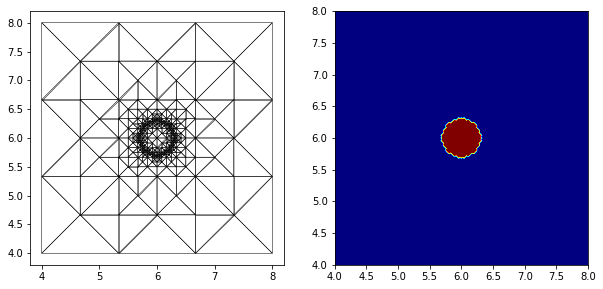

In [10]:
from dune.fem.plotting import plotComponents
import matplotlib.pyplot as pyplot
from dune.fem.function import levelFunction, partitionFunction

# can construct a vtk writer that generates a sequence of files
# vtk = gridView.sequencedVTK("crystal", pointdata=[u_h],
#           celldata=[levelFunction(gridView), partitionFunction(gridView)])

matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams['figure.figsize'] = [10, 5]
plotComponents(u_h, cmap=pyplot.cm.jet, show=[0])

We set ```dt``` and the initial time t=0.

In [11]:
scheme.model.dt = 0.0005
t = 0.0

Finally we set up the time loop and solve the problem - each time this cell is run the simulation will progress to the given ```endTime``` and then the result is shown. The simulation can be progressed further by rerunning the cell while increasing the ```endTime```.

0.02600000000000002

0.04950000000000004 7412


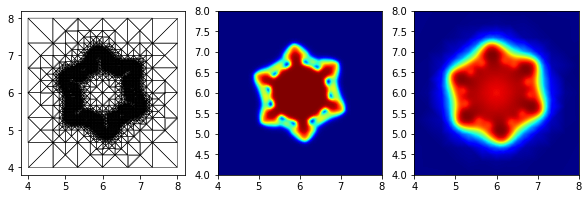

In [12]:
endTime = 0.05
while t < endTime:
    u_h_n.assign(u_h)
    scheme.solve(target=u_h)
    print(t, gridView.size(0), end="\r")
    t += scheme.model.dt
    fem.mark(indicator,1.4,1.2,0,maxLevel)
    fem.adapt(u_h)
    fem.loadBalance(u_h)
    # vtk()                # store result in vtk file
print()

plotComponents(u_h, cmap=pyplot.cm.jet)